#### Estudo de Correlação 
> Temperatura / Cobertura Vegetal
  
<sub>gds - Google Dataset</sub>  
<sub>lz - Listed Zeros</sub>  
<sub>corr - Correlation</sub>  
<sub>avr - Average</sub> 

---  

In [1]:
# Importing GEE dependencies
from helpers.geeApi import PrecorsiaGee

# Importing image processing tools
from helpers.imageCorrelator import ImageCorrelator
from helpers.imageProcessor import ImageProcessor

# Importing data processing tools
import matplotlib.pyplot as plt
import numpy as np
import json

#### Image availability list

Add dataset's configuration 

In [2]:
# ! Execute once per session
PrecorsiaGee.init()

In [3]:
START, END = PrecorsiaGee.date_daily('2016-01-01', 2880)
geolocation = [-57.414653412450235, -13.99834272152354]
image_scale = 10000
round_factor = 9

In [4]:
reference_dataset = 'GOOGLE/DYNAMICWORLD/V1'
comparable_dataset = 'UCSB-CHG/CHIRPS/DAILY'

reference_band_name, reference_band_range = 'grass', [0, 1]
comparable_band_name, comparable_band_range = 'precipitation', [0, 102]

In [5]:
gds_one = PrecorsiaGee(reference_dataset, reference_band_range)
gds_two = PrecorsiaGee(comparable_dataset, comparable_band_range)

Configure the filter and get the list of images

In [6]:
gds_one_list = gds_one.list(geolocation, [START, END])
gds_two_list = gds_two.list(geolocation, [START, END])
gds_one_list, gds_two_list = PrecorsiaGee.correlate_dates(gds_one_list, gds_two_list, round_factor)

#### Image requests and data acquisition

commit to memory

In [7]:
PrecorsiaGee.download_images(gds_one_list, gds_one, reference_band_name, geolocation, image_scale)
PrecorsiaGee.download_images(gds_two_list, gds_two, comparable_band_name, geolocation, image_scale)

GOOGLE/DYNAMICWORLD/V1 Progress: 100.00% | Estimated time: 0.00s          

UCSB-CHG/CHIRPS/DAILY Progress: 100.00% | Estimated time: 0.00s          



#### Processing and visualizing the data

filter using zero counting

In [8]:
# ! will delete from buffer
process = ImageProcessor([gds_one_list, gds_two_list])
[gds_one_lz, gds_two_lz] = process.zero_counting_filter()

Group by date and plot a correlation graph

In [9]:
corr_list = PrecorsiaGee.connected_correlation(gds_one_lz, gds_two_lz, round_factor)

Plotting the correlation graph

In [10]:
title = {'title': f'Correlation between {gds_one.dataset} ({reference_band_name}) \
and \n{gds_two.dataset} ({comparable_band_name}) at {geolocation}',
'xlabel': gds_one.dataset, 'ylabel': gds_two.dataset}

In [11]:
gds_two_dataset_name = gds_two.dataset.replace('/', '_')

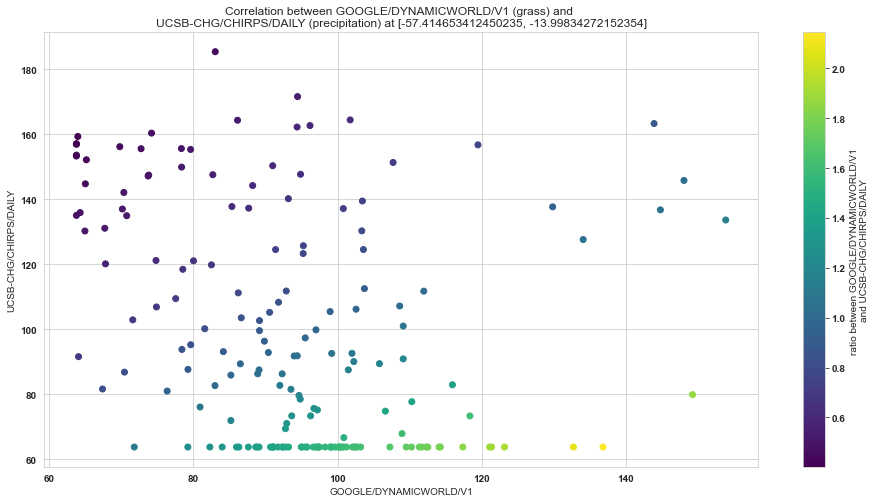

In [12]:
corr_study = ImageCorrelator(corr_list)
corr_avr = corr_study.calculate_correlation()
ImageCorrelator.plot(corr_avr, title)
plt.savefig(f'plots/{gds_two_dataset_name}_normal.jpg', dpi=150)
plt.show()

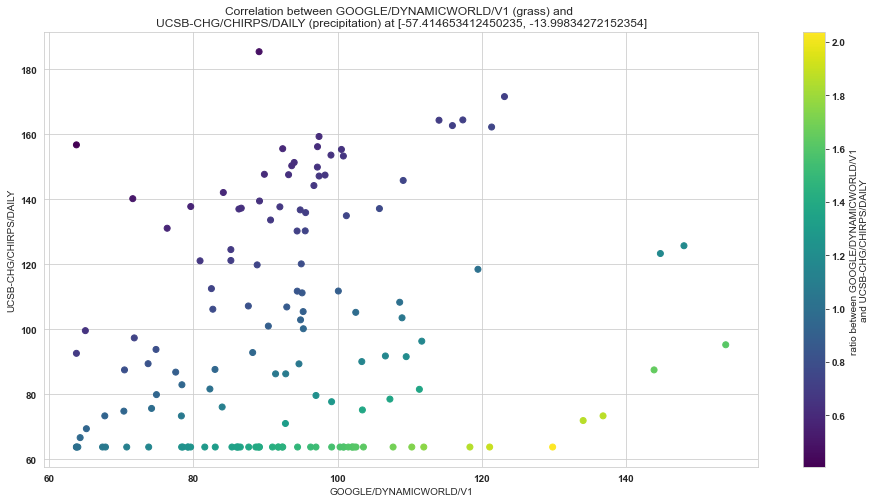

Best shift: 33, Best correlation: 0.176399743353685


In [13]:
x_values, y_values = zip(*corr_avr)
best_shifted_corr_avr = []
best_corr = -np.inf
best_shift = 0

for i in range(int(len(x_values)/2)):
    shifted_y_values = y_values[:-i] if i != 0 else y_values
    shifted_x_values = x_values[i:]
    shifted_corr_avr = list(zip(shifted_x_values, shifted_y_values))
    corr = np.corrcoef(shifted_x_values, shifted_y_values)[0, 1]

    if corr > best_corr:
        best_corr = corr
        best_shift = i
        best_shifted_corr_avr = shifted_corr_avr

ImageCorrelator.plot(best_shifted_corr_avr, title)
plt.savefig(f'plots/{gds_two_dataset_name}_shifted.jpg', dpi=150)
plt.show()

print(f"Best shift: {best_shift}, Best correlation: {best_corr}")

In [14]:
data = {"best_correlation": best_corr}
data["best_shift"] = best_shift
data["correlation_list"] = corr_list
with open(f'data/corr_list_{gds_two_dataset_name}.json', 'w') as file:
    json.dump(data, file)